In [3]:
#Note: before launching Jupyter lab, need to export: export DJANGO_SETTINGS_MODULE=crypto_signal.settings
import django
django.setup()

In [4]:
from crypto_track.models import CryptoCandle, PyTrends, Bank, SignalSimulation, Simulation
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

In [5]:
import pandas as pd
import sqlite3

conn = sqlite3.connect("db.sqlite3")
df = pd.read_sql_query("select a.*, b.trend_ratio from crypto_track_cryptocandle as a left join crypto_track_pytrends as b on a.search_trend_id = b.date order by period_start_timestamp;", conn)
df.head()

,id,crypto_traded,currency_quoted,period_interval,period_start_timestamp,period_low,period_open,period_close,period_high,period_volume,data_source,search_trend_id,update_timestamp,trend_ratio
0,21227,BTC,USD,1d,2013-01-14T00:00:00Z,14.53295,14.53737,14.53295,14.53737,295,Nomics https://api.nomics.com/v1/candles,2013-01-14,2018-11-28 15:39:20.146682,0.6
1,21228,BTC,USD,1d,2013-01-15T00:00:00Z,14.52479,14.52479,14.76857,14.76857,945,Nomics https://api.nomics.com/v1/candles,2013-01-15,2018-11-28 15:39:20.146682,NaN
2,21229,BTC,USD,1d,2013-01-16T00:00:00Z,14.74920,14.74920,15.02460,15.02460,2419,Nomics https://api.nomics.com/v1/candles,2013-01-16,2018-11-28 15:39:20.146682,2.0
3,21230,BTC,USD,1d,2013-01-17T00:00:00Z,15.13679,15.13679,15.96468,15.96468,8011,Nomics https://api.nomics.com/v1/candles,2013-01-17,2018-11-28 15:39:20.146682,NaN
4,21231,BTC,USD,1d,2013-01-18T00:00:00Z,15.74880,16.03437,15.99800,16.26278,5762,Nomics https://api.nomics.com/v1/candles,2013-01-18,2018-11-28 15:39:20.146682,NaN


In [6]:
from django.shortcuts import get_object_or_404
# attach next day's close price so we can estimate
candle_data = list(CryptoCandle.objects.all().values().order_by('-period_start_timestamp'))
next_candle = None
for i, cd in enumerate(candle_data):
    
    try:
        candle = get_object_or_404(CryptoCandle, pk=cd['id'])
        tr = candle.search_trend.trend_ratio
    except:
        tr = None
        
    candle_data[i]['trend_ratio'] = tr
    candle_data[i]['next_candle_period_close'] = next_candle
    next_candle = candle_data[i]['period_close']

In [7]:
print(candle_data[0])

{'id': 23371, 'crypto_traded': 'BTC', 'currency_quoted': 'USD', 'period_interval': '1d', 'period_start_timestamp': '2018-11-28T00:00:00Z', 'search_trend_id': None, 'period_low': Decimal('3610.0268500000'), 'period_open': Decimal('3820.5839900000'), 'period_close': Decimal('4217.6785300000'), 'period_high': Decimal('4343.7308900000'), 'period_volume': Decimal('1147997835.0000000000'), 'data_source': 'Nomics https://api.nomics.com/v1/candles', 'update_timestamp': datetime.datetime(2018, 11, 28, 15, 39, 20, 146682, tzinfo=<UTC>), 'trend_ratio': None, 'next_candle_period_close': None}


In [8]:
# sort by start date ascending
candle_data.sort(key=lambda item: item['period_start_timestamp'])

In [9]:
print(candle_data[0])

{'id': 21227, 'crypto_traded': 'BTC', 'currency_quoted': 'USD', 'period_interval': '1d', 'period_start_timestamp': '2013-01-14T00:00:00Z', 'search_trend_id': datetime.date(2013, 1, 14), 'period_low': Decimal('14.5329500000'), 'period_open': Decimal('14.5373700000'), 'period_close': Decimal('14.5329500000'), 'period_high': Decimal('14.5373700000'), 'period_volume': Decimal('295.0000000000'), 'data_source': 'Nomics https://api.nomics.com/v1/candles', 'update_timestamp': datetime.datetime(2018, 11, 28, 15, 39, 20, 146682, tzinfo=<UTC>), 'trend_ratio': Decimal('0.60000'), 'next_candle_period_close': Decimal('14.7685700000')}


In [21]:
df = pd.DataFrame(candle_data)
df.head()

,crypto_traded,currency_quoted,data_source,id,next_candle_period_close,period_close,period_high,period_interval,period_low,period_open,period_start_timestamp,period_volume,search_trend_id,trend_ratio,update_timestamp
0,BTC,USD,Nomics https://api.nomics.com/v1/candles,21227,14.7685700000,14.5329500000,14.5373700000,1d,14.5329500000,14.5373700000,2013-01-14T00:00:00Z,295.0000000000,2013-01-14,0.60000,2018-11-28 15:39:20.146682+00:00
1,BTC,USD,Nomics https://api.nomics.com/v1/candles,21228,15.0246000000,14.7685700000,14.7685700000,1d,14.5247900000,14.5247900000,2013-01-15T00:00:00Z,945.0000000000,2013-01-15,None,2018-11-28 15:39:20.146682+00:00
2,BTC,USD,Nomics https://api.nomics.com/v1/candles,21229,15.9646800000,15.0246000000,15.0246000000,1d,14.7492000000,14.7492000000,2013-01-16T00:00:00Z,2419.0000000000,2013-01-16,2.00000,2018-11-28 15:39:20.146682+00:00
3,BTC,USD,Nomics https://api.nomics.com/v1/candles,21230,15.9980000000,15.9646800000,15.9646800000,1d,15.1367900000,15.1367900000,2013-01-17T00:00:00Z,8011.0000000000,2013-01-17,None,2018-11-28 15:39:20.146682+00:00
4,BTC,USD,Nomics https://api.nomics.com/v1/candles,21231,15.9273000000,15.9980000000,16.2627800000,1d,15.7488000000,16.0343700000,2013-01-18T00:00:00Z,5762.0000000000,2013-01-18,None,2018-11-28 15:39:20.146682+00:00


In [22]:
df.dtypes

crypto_traded                            object
currency_quoted                          object
data_source                              object
id                                        int64
next_candle_period_close                 object
period_close                             object
period_high                              object
period_interval                          object
period_low                               object
period_open                              object
period_start_timestamp                   object
period_volume                            object
search_trend_id                          object
trend_ratio                              object
update_timestamp            datetime64[ns, UTC]
dtype: object

In [12]:
# drop records missing trend_ratio
df.dropna(subset=['next_candle_period_close'], inplace=True)

In [23]:
import numpy as np
df.replace( '',np.nan, regex=True)
df['period_close'] = df.period_close.astype(float)
df['period_high'] = df.period_high.astype(float)
df['period_low'] = df.period_low.astype(float)
df['period_open'] = df.period_open.astype(float)
df['period_volume'] = df.period_volume.astype(float)
#df['next_candle_period_close'] = df.next_candle_period_close.astype(float)
df['trend_ratio'] = df.trend_ratio.astype(float)
df['period_datetime'] = pd.to_datetime(df['period_start_timestamp'], errors='coerce')
#df['id'] = df.id.astype(object)
# df = df[(len(df.next_candle_period_close) > 0)]
#df['next_candle_period_close'] = df.next_candle_period_close.astype(float)
df.dtypes


crypto_traded                            object
currency_quoted                          object
data_source                              object
id                                        int64
next_candle_period_close                 object
period_close                            float64
period_high                             float64
period_interval                          object
period_low                              float64
period_open                             float64
period_start_timestamp                   object
period_volume                           float64
search_trend_id                          object
trend_ratio                             float64
update_timestamp            datetime64[ns, UTC]
period_datetime                  datetime64[ns]
dtype: object

In [24]:
df.describe()

,id,period_close,period_high,period_low,period_open,period_volume,trend_ratio
count,2145.000000,2145.000000,2145.000000,2145.000000,2145.000000,2.145000e+03,2133.000000
mean,22299.000000,2171.433819,2390.399911,1836.609461,2169.737857,6.578764e+08,1.053718
std,619.352484,3369.689915,4650.454352,2736.230637,3370.813828,1.749643e+09,1.227227
min,21227.000000,14.532950,14.537370,0.010000,14.524790,2.950000e+02,0.173910
25%,21763.000000,273.525820,304.811150,260.000010,272.756320,2.318408e+06,0.420000
50%,22299.000000,580.479360,601.104420,544.349920,580.390050,1.602837e+07,0.568180
75%,22835.000000,2391.224410,2646.688500,1950.000000,2384.057430,3.727769e+08,1.000000
max,23371.000000,19409.628430,136401.827730,15377.620880,19393.650760,1.781027e+10,12.500000


In [25]:
df['trend_ratio_prior'] = df.trend_ratio.shift(1)
df.head()

,crypto_traded,currency_quoted,data_source,id,next_candle_period_close,period_close,period_high,period_interval,period_low,period_open,period_start_timestamp,period_volume,search_trend_id,trend_ratio,update_timestamp,period_datetime,trend_ratio_prior
0,BTC,USD,Nomics https://api.nomics.com/v1/candles,21227,14.7685700000,14.53295,14.53737,1d,14.53295,14.53737,2013-01-14T00:00:00Z,295.0,2013-01-14,0.6,2018-11-28 15:39:20.146682+00:00,2013-01-14,NaN
1,BTC,USD,Nomics https://api.nomics.com/v1/candles,21228,15.0246000000,14.76857,14.76857,1d,14.52479,14.52479,2013-01-15T00:00:00Z,945.0,2013-01-15,NaN,2018-11-28 15:39:20.146682+00:00,2013-01-15,0.6
2,BTC,USD,Nomics https://api.nomics.com/v1/candles,21229,15.9646800000,15.02460,15.02460,1d,14.74920,14.74920,2013-01-16T00:00:00Z,2419.0,2013-01-16,2.0,2018-11-28 15:39:20.146682+00:00,2013-01-16,NaN
3,BTC,USD,Nomics https://api.nomics.com/v1/candles,21230,15.9980000000,15.96468,15.96468,1d,15.13679,15.13679,2013-01-17T00:00:00Z,8011.0,2013-01-17,NaN,2018-11-28 15:39:20.146682+00:00,2013-01-17,2.0
4,BTC,USD,Nomics https://api.nomics.com/v1/candles,21231,15.9273000000,15.99800,16.26278,1d,15.74880,16.03437,2013-01-18T00:00:00Z,5762.0,2013-01-18,NaN,2018-11-28 15:39:20.146682+00:00,2013-01-18,NaN


In [26]:
df.drop(['search_trend_id'], axis=1, inplace=True)
df.to_csv('ml_output.csv')

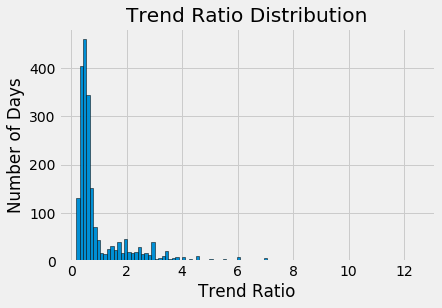

In [27]:
import matplotlib.pyplot as plt
# Histogram of the Energy Star Score
plt.style.use('fivethirtyeight')
plt.hist(df['trend_ratio'].dropna(), bins = 100, edgecolor = 'k');
plt.xlabel('Trend Ratio'); plt.ylabel('Number of Days'); 
plt.title('Trend Ratio Distribution');

In [18]:
# I want to flag the trends that are missing and will be replaced
#df['missing_trend'] = 

In [28]:
df.trend_ratio.fillna(df['trend_ratio_prior'],  inplace=True)

In [29]:
df.drop(['trend_ratio_prior'], axis=1, inplace=True)
df.head()

,crypto_traded,currency_quoted,data_source,id,next_candle_period_close,period_close,period_high,period_interval,period_low,period_open,period_start_timestamp,period_volume,trend_ratio,update_timestamp,period_datetime
0,BTC,USD,Nomics https://api.nomics.com/v1/candles,21227,14.7685700000,14.53295,14.53737,1d,14.53295,14.53737,2013-01-14T00:00:00Z,295.0,0.6,2018-11-28 15:39:20.146682+00:00,2013-01-14
1,BTC,USD,Nomics https://api.nomics.com/v1/candles,21228,15.0246000000,14.76857,14.76857,1d,14.52479,14.52479,2013-01-15T00:00:00Z,945.0,0.6,2018-11-28 15:39:20.146682+00:00,2013-01-15
2,BTC,USD,Nomics https://api.nomics.com/v1/candles,21229,15.9646800000,15.02460,15.02460,1d,14.74920,14.74920,2013-01-16T00:00:00Z,2419.0,2.0,2018-11-28 15:39:20.146682+00:00,2013-01-16
3,BTC,USD,Nomics https://api.nomics.com/v1/candles,21230,15.9980000000,15.96468,15.96468,1d,15.13679,15.13679,2013-01-17T00:00:00Z,8011.0,2.0,2018-11-28 15:39:20.146682+00:00,2013-01-17
4,BTC,USD,Nomics https://api.nomics.com/v1/candles,21231,15.9273000000,15.99800,16.26278,1d,15.74880,16.03437,2013-01-18T00:00:00Z,5762.0,NaN,2018-11-28 15:39:20.146682+00:00,2013-01-18


In [100]:
df.describe()

,id,next_candle_period_close,period_close,period_high,period_low,period_open,period_volume,trend_ratio
count,2144.000000,2144.000000,2144.000000,2144.000000,2144.000000,2144.000000,2.144000e+03,2142.000000
mean,22298.500000,2172.439836,2170.479413,2389.488842,1835.782307,2168.967872,6.576478e+08,1.059574
std,619.063809,3370.153821,3370.186036,4651.347783,2736.600724,3371.411521,1.750019e+09,1.230960
min,21227.000000,14.768570,14.532950,14.537370,0.010000,14.524790,2.950000e+02,0.173910
25%,21762.750000,273.717835,273.235800,304.807163,260.000007,272.688993,2.313262e+06,0.420262
50%,22298.500000,580.617880,580.338285,601.082770,543.300620,580.065015,1.602612e+07,0.571430
75%,22834.250000,2392.712435,2386.243825,2646.688500,1940.276093,2352.864360,3.723883e+08,1.018750
max,23370.000000,19409.628430,19409.628430,136401.827730,15377.620880,19393.650760,1.781027e+10,12.500000


In [101]:
# drop records missing trend_ratio
df.dropna(subset=['trend_ratio'], inplace=True)

In [102]:
df.describe()

,id,next_candle_period_close,period_close,period_high,period_low,period_open,period_volume,trend_ratio
count,2142.000000,2142.000000,2142.000000,2142.000000,2142.000000,2142.000000,2.142000e+03,2142.000000
mean,22298.498133,2172.491784,2170.713663,2389.771415,1835.970583,2169.217177,6.576135e+08,1.059574
std,618.489690,3371.115663,3371.249050,4653.080247,2737.424810,3372.483411,1.750707e+09,1.230960
min,21227.000000,14.768570,14.532950,14.537370,0.010000,14.524790,2.950000e+02,0.173910
25%,21763.250000,274.065620,273.589825,304.878190,260.000020,272.840238,2.320923e+06,0.420262
50%,22298.500000,580.617880,580.338285,601.082770,543.300620,580.065015,1.602612e+07,0.571430
75%,22833.750000,2389.564215,2373.905808,2645.329250,1933.965305,2341.261320,3.721282e+08,1.018750
max,23369.000000,19409.628430,19409.628430,136401.827730,15377.620880,19393.650760,1.781027e+10,12.500000


In [103]:
# Create target object and call it y
y = df.next_candle_period_close

In [112]:
features = ['period_close', 'period_high', 'period_low', 'period_open', 'period_volume', 'trend_ratio', 'id']
X = df[features]

In [113]:
# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y)

In [114]:
val_X.head()

,period_close,period_high,period_low,period_open,period_volume,trend_ratio,id
1472,898.06466,934.99162,883.20000,895.21422,4.038828e+07,0.38889,22699
1769,7776.06758,7990.91052,6335.27751,7694.58679,2.680646e+09,0.59259,22996
1415,741.68506,770.46735,720.23542,740.78424,3.359535e+07,0.54839,22642
1369,640.80830,673.01216,611.83035,635.52710,3.354204e+07,0.47619,22596
1365,618.94430,638.46171,608.86365,614.99578,2.847190e+07,0.54545,22592


In [115]:
val_y.head()

1472     919.20167
1769    8029.89819
1415     753.25228
1369     640.33117
1365     640.42363
Name: next_candle_period_close, dtype: float64

In [116]:
# Specify Model
btc_model = DecisionTreeRegressor()
# Fit Model
btc_model.fit(train_X, train_y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [117]:
# Make validation predictions and calculate mean absolute error
val_predictions = btc_model.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MAE when not specifying max_leaf_nodes: {:,.0f}".format(val_mae))

Validation MAE when not specifying max_leaf_nodes: 102


In [118]:
print("Making predictions for the following 5 candles:")
print(X.head())
print("The predictions are")
print(btc_model.predict(X.head()))
print("The actuals are")
print(y.head())

Making predictions for the following 5 candles:
   period_close  period_high  period_low  period_open  period_volume  \
0      14.53295     14.53737    14.53295     14.53737          295.0   
1      14.76857     14.76857    14.52479     14.52479          945.0   
2      15.02460     15.02460    14.74920     14.74920         2419.0   
3      15.96468     15.96468    15.13679     15.13679         8011.0   
5      15.92730     16.05480    15.63659     16.00379         3541.0   

   trend_ratio     id  
0          0.6  21227  
1          0.6  21228  
2          2.0  21229  
3          2.0  21230  
5          3.0  21232  
The predictions are
[14.76857 15.0246  15.0246  15.998   16.1057 ]
The actuals are
0    14.76857
1    15.02460
2    15.96468
3    15.99800
5    16.10570
Name: next_candle_period_close, dtype: float64


In [119]:
correlations_data = df.corr()['next_candle_period_close'].sort_values()

In [120]:
correlations_data

trend_ratio                -0.297301
id                          0.700258
period_high                 0.822883
period_volume               0.868399
period_low                  0.969545
period_open                 0.995236
period_close                0.997732
next_candle_period_close    1.000000
Name: next_candle_period_close, dtype: float64

In [36]:
df_priceclose = df.iloc[:,[5,14]]
df_priceclose.head()

,period_close,period_datetime
0,14.53295,2013-01-14
1,14.76857,2013-01-15
2,15.02460,2013-01-16
3,15.96468,2013-01-17
4,15.99800,2013-01-18


In [38]:
df_priceclose.columns = ['y', 'ds']
df_priceclose.head()

,y,ds
0,14.53295,2013-01-14
1,14.76857,2013-01-15
2,15.02460,2013-01-16
3,15.96468,2013-01-17
4,15.99800,2013-01-18


In [46]:
from fbprophet import Prophet
crypto_prophet = Prophet(daily_seasonality=False,  
                                  weekly_seasonality=False, 
                                  yearly_seasonality=True,
                                  changepoint_prior_scale=0.05)
        
crypto_prophet.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
crypto_prophet = Prophet()
crypto_prophet.fit(df_priceclose)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [47]:
future = crypto_prophet.make_future_dataframe(periods=365)
future.head()

,ds
0,2013-01-14
1,2013-01-15
2,2013-01-16
3,2013-01-17
4,2013-01-18


In [48]:
forecast = crypto_prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
2505,2019-11-24,7214.414376,3783.738400,10409.512504
2506,2019-11-25,7299.681867,4108.636652,10528.256452
2507,2019-11-26,7389.656462,4081.288028,10545.459156
2508,2019-11-27,7481.965995,4199.500032,10790.859499
2509,2019-11-28,7605.055382,4254.025687,11019.763388


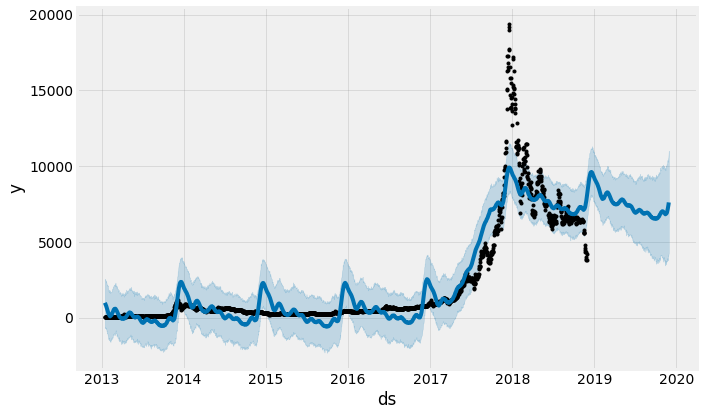

In [49]:
fig1 = crypto_prophet.plot(forecast)


In [50]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-14,-155.928463,-686.941729,2555.109538,-155.928463,-155.928463,1138.296874,1138.296874,1138.296874,0.963192,0.963192,0.963192,1137.333682,1137.333682,1137.333682,0.0,0.0,0.0,982.368411
1,2013-01-15,-153.490465,-599.833096,2562.149802,-153.490465,-153.490465,1100.298276,1100.298276,1100.298276,-4.090463,-4.090463,-4.090463,1104.388739,1104.388739,1104.388739,0.0,0.0,0.0,946.807811
2,2013-01-16,-151.052468,-696.979630,2499.996840,-151.052468,-151.052468,1054.982107,1054.982107,1054.982107,-13.990045,-13.990045,-13.990045,1068.972152,1068.972152,1068.972152,0.0,0.0,0.0,903.929639
3,2013-01-17,-148.614471,-650.291780,2465.088025,-148.614471,-148.614471,1031.534626,1031.534626,1031.534626,0.627709,0.627709,0.627709,1030.906917,1030.906917,1030.906917,0.0,0.0,0.0,882.920155
4,2013-01-18,-146.176474,-741.160241,2341.180153,-146.176474,-146.176474,992.390335,992.390335,992.390335,2.279473,2.279473,2.279473,990.110862,990.110862,990.110862,0.0,0.0,0.0,846.213861
